# Proposing A Profitable App Profile from Google Play Store

## Introduction

This is a data analyst project idea borrowed directly from [dataquest.io](https://www.dataquest.io/projects/guided-project-a-profitable-app-profiles-for-the-app-store-and-google-play-markets-2/). Modifications have been made to project instructions.

The aim of the project is to analyse the app data and make decision regarding what kind of apps that are likely to attract the most users.

Links to the documentation for the datasets below for more details:

- Apple store [dataset's documentation](https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps)

- Google Play store [dataset's documentation](https://www.kaggle.com/datasets/lava18/google-play-store-apps)

## Data Import and Preliminary Inspection

### Import required Python libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import the datasets

There 2 datasets - Google playstore and Apple store.

We import both and store them as panda dataframes.

In [2]:
# Data import
#iodata = pd.read_csv('AppleStore.csv')  # ios - iOS apple store
playstore = pd.read_csv('googleplaystore.csv')

### Inspect imported datasets

Use pandas dataframe methods like `head`, `info`, `describe` to inspect the data

In [3]:
# Info on dataset shape (rows/columns) and data types
print(playstore.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None


In [4]:
# Inspect for columns with readily analyzable data
playstore.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [5]:
# Check total null entries per column
playstore.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [6]:
# Preview of first 3 rows
playstore.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


### Preliminary observations from inspecting the raw dataset:
- **Dataset Size**: there are 10,841 apps in the dataset, with 13  columns. Recall that we only interested in apps that are free and for English-speaking users.
  
- **Data Type Formats**: Only the 'Rating' column is a non-string format (float64); the rest are strings (even the ones that seemly contain numbers). Some of these columns (like 'Installs', 'Price', 'Reviews', and 'Last Updated') contain data that we will possibly perform analysis on, will require type conversions.

- **Null Data**: The 'Rating' has column has the highest number of `NULL` entries (1,474); other columns have between 0 - 8, which is good.

- **Erroneous Data**: Note also the max rating value of 19.0 - very unusual and most likely erroneous data.

With these preliminary observations noted, let's proceed with cleaning the data.

## Data Cleaning

### Steps

The following cleaning steps will be carried out for both data sets:

1. Data type conversions
2. Clean 'Rating' column
3. Filter out remaining `NULL` entries
4. Filter out duplicates
5. Filter out non-English apps
6. Filter our apps that are not free
7. Check for blanks and filter out erroneous data
8. Lastly, we reset index for sequential numbering


### Columns datatype conversions


#### 'Installs' column

In [7]:
## Pre-inspected with bar plot of `value_counts` (`dropna` set to False to include nulls)
## Column with 'Free' spotted - locate row with
## playstore[playstore.Installs == 'Free']
## Incorrect datascrape for this row; drop the row

# Filter out the 
mask = playstore.Installs == 'Free'
playstore = playstore[~mask]

# 'Installs' column object to int64 dtype
playstore['Installs'] = playstore['Installs'].str.replace('+', '').str.replace(',','').astype('int64')

#### 'Price' column

In [8]:
# Pre-inspected with plot of `value_counts` (`dropna` set to False to include nulls)

# 'Price' column object to float64 dtype
playstore['Price'] = playstore['Price'].str.replace('$', '').astype('float64')

#### 'Size' column

In [9]:
## Pre-inspected with plot of `value_counts` (`dropna` set to False to include nulls)
## We learn that there are 2 multipliers - M and k; rest columns have text "Varies with device"
## We will create a Size-in-kbytes column with corresponding the values

# Extract size multiplier (i.e.'M' or 'k') to integer values
extract = playstore.Size.str[-1]
mmap = {'M':1000, 'k':1}
SizeMultiplier = np.array([mmap[x] if x in mmap.keys() else np.nan for x in extract])

# Extract the 'Size' integer portion and broadcast to new column 'SizeBytes' float dtype column
playstore['SizeKBytes'] = pd.to_numeric(playstore.Size.str[:-1], errors='coerce') * SizeMultiplier

#### 'Reviews' column

In [10]:
# Convert 'Reviews' to numeric type
playstore['Reviews'] = pd.to_numeric(playstore['Reviews'])

### Clean the 'Rating' column

We had noted a row with an unusually high rating 19.0; this is probably an error (1.9 instead of 19.0) but we don't know for sure. So best option is eliminate the row.

We will use a boolean mask to filter out the row. Then we inspect the resultant 'Rating' column with a plot of its values to confirm clean.

In [11]:
# Use a boolean mask to filter out 19.0 rating
mask = playstore['Rating'] == 19.0
playstore = playstore[~mask]

### Remove `NULL` entries

We simply drop all rows containing at least 1 `NaN` or `Null` entry with pandas `dropna` method.

In [12]:
# Drop all rows with `Null` data
playstore = playstore.dropna()

### Remove duplicates

In [13]:
# Check for 'App' duplicates
playstore[playstore['App'].duplicated()].shape

(700, 14)

There are 700 app duplicates. 

We do a bit of inspection by sorting the dataset by app name; it shows that some of the duplicates have varying number of reviews. 

In [27]:
# Sort duplicates by 'App' and inspect the last 4th and 3rd rows
playstore[playstore['App'].duplicated()].sort_values('App').iloc[-4:-2]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,SizeKBytes
3014,"theScore: Live Sports Scores, News, Stats & Vi...",SPORTS,4.4,133825,34M,10000000,Free,0.0,Everyone 10+,Sports,"July 25, 2018",6.17.2,4.4 and up,34000.0
3085,"theScore: Live Sports Scores, News, Stats & Vi...",SPORTS,4.4,133833,34M,10000000,Free,0.0,Everyone 10+,Sports,"July 25, 2018",6.17.2,4.4 and up,34000.0


We will retain the duplicates with the highest reviews (infering that these are the most recent), and drop the rest. 

'Review' column is already in numeric format so we just sort the dataset by 'App' and 'Reviews', then find and filter out duplicates from the sorted dataset.

In [15]:
# Sort the dataset by 'App' ascending and 'Reviews' descending
playstore.sort_values(by=['App','Reviews'],ascending=[True,False])

# Make a mask of the duplicates (from the sorted dataset)
mask = playstore['App'].duplicated()

# Filter out duplicates 
playstore = playstore[~mask]

### Remove non-English apps

For this, we analysis the name column 'App' and remove all rows with non-English text words (i.e. words containing characters that are not used in English text).

A general rule-of-thumb for the ASCII ** is that English text characters have Unicode numeric values 0 - 127. So we can assume that any character with value greater than 127 is a non-English text character.

We apply this rule-of-thumb with a quick function `nenglish` to check for non-English text strings in the app names. The function employs Python's inbuilt `ord()` function which returns the Unicode numeric value of any character.

In [16]:
# nenglish function -> returns true for non-English language strings 
def nenglish(string):
    count = 0
    for char in string:
        if ord(char) > 127: 
            count += 1
            if count > 3: return True
    return False

The code below generates a list of all app names in the dataset and runs the list through the `nenglish` function as a list comprehension. 

The result is a Numpy boolean mask which we then use to extract the non-English apps.

In [17]:
# Run a list of App names through the `nenglish()` function to get a boolean mask of the non-English apps 
non_english_mask = np.array([nenglish(app) for app in playstore['App'].tolist()])

# Apply mask to dataset to get the non-English apps
non_english_apps = playstore[non_english_mask]
non_english_apps.tail(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,SizeKBytes
10098,Ey Sey Storytime រឿងនិទានតាឥសី,FAMILY,4.7,1327,44M,10000,Free,0.0,Everyone,Education;Education,"May 18, 2017",1.2.2,4.0.3 and up,44000.0
10763,FP Разбитый дисплей,FAMILY,4.5,922,552k,50000,Free,0.0,Everyone,Entertainment,"September 20, 2014",1.1,1.6 and up,552.0


Reverse the non-English apps mask to filter out the non-English apps

In [18]:
# Filter out non_English apps
playstore = playstore[~non_english_mask]

### Remove all paid apps

We first investigate the 'Type' and 'Price' columns with `value-counts` to a bar plot to visualise the prices.

In [19]:
# Check 'Type' value_counts plot --> 2 values: 'Free' and 'Paid'
playstore.Type.value_counts()

# Use boolean mask to filter out 'Paid' apps
mask = playstore['Type'] == 'Paid'
playstore = playstore[~mask]

### Review cleaning results

This marks the end of the data cleaning process.

We export a copy of the cleaned dataset to a CSV file before we proceed to data analysis.

In [28]:
# Export cleaning results to CSV file
playstore.to_csv('googleplaystore_rev.csv', index=False)

## Data Analysis

Lets recall the aim of the project - to analyse the playstore data and propose an app profile which is most likely to attract the highest number of users. This means that the app profile should be able to demostrate the following attributes:

- **Popularity** - high downloads, high number of reviews

- **High user engagement** - high review count, top-rated

Additionally, it is also essential that the profile avoid highly competitive categories where it's chances of success will be severely limited by massively established and already successful competitors. This means we must also aim for a **Niche category** that still satisfies the popularity and user engagement requirements.

### Category frequency table

To determine which categories that best satisfy the stated requirements of our app profile, we look at the **app category trends** in our dataset. We extract pivoted data from our original "long-form" dataset into a "wide-form" Category frequency table. This table will contain categorical information about:
- **total number of apps**

- **total and averaged downloads**

- **total and average review counts**

- **average rating**

It is possible that some categories may have a high volume of apps which could in turn affect the total number of downloads and/or reviews that they get, so the computed averages (the total value counts divided by the number of apps in the category) are used to give a more balanced view.

**Notes on the Category frequecy table**:

1. Due to the massive amounts of downloads and reviews in some apps (and because we are dealing with categorical sums), the downloads and number of reviews are reduced to units per million and units per one hundred thousand respectively.
  
2. The dataset does not provide specify downloads figures, rather they are provided as estimates (e.g. 50,000+, 100,000+, etc.). It is therefore possible that two apps, with widely varying downloads such as 501,000 and 997,100, would both be recorded as 500,000+, thereby introducing very misleading approximations into the dataset. We will however work with the dataset as it is, and make our deductions based on it.

The code below takes us through the steps of building the frequency table.

In [21]:
## Build the Category Frequency Table (table0)

# Get the number of apps per category, sorted by category name
table0 = playstore.Category.value_counts().reset_index()
table0.columns = ['Category', 'NumOfApp']
table0 = table0.sort_values(by='Category', ascending=True)

# Get Total and Average Downloads per Category (in millions)
df = (playstore.Installs.groupby(playstore.Category).sum()).reset_index()
df = df.sort_values(by='Category', ascending=True)
table0['TotInstalls'] = df['Installs'].values / 1000000
table0['AvgInstalls'] = round(table0.TotInstalls / table0.NumOfApp, 2)

# Get Total and Average Review counts per Category (in hundred thousands) 
df = playstore.Reviews.groupby(playstore.Category).sum().reset_index()
table0['TotReviews'] = df['Reviews'].values / 100000
table0['AvgReviews'] = round(table0.TotReviews / table0.NumOfApp, 2)

table0.head(3) # View first 3 rows

,Category,NumOfApp,TotInstalls,AvgInstalls,TotReviews,AvgReviews
26,ART_AND_DESIGN,54,99.2111,1.84,10.85041,0.20
23,AUTO_AND_VEHICLES,63,43.7698,0.69,9.92286,0.16
32,BEAUTY,37,13.4162,0.36,1.85749,0.05


In [22]:
## Broadcast Installs and Reviews to reduced units per 1 million and 100k respectively
playstore.loc[:,'Installs_rd'] = playstore.Installs / 1000000
playstore.loc[:,'Reviews_rd'] = playstore.Reviews / 100000
playstore.loc[:,'Ratio'] = round(playstore.Reviews_rd / playstore.Installs_rd, 4)

## Broadcast Analysis indices to Category freq table
table0.loc[:,'v2'] = round(table0.TotReviews / table0.NumOfApp, 1)              # Measure of Engagements
table0.loc[:,'v3'] = round(1 / (table0.AvgInstalls / table0.NumOfApp), 1)       # Measure of Saturation

### Estimating Popularity & User Engagement

#### Most Downloaded & Reviewed Categories

Since our dataset contains only discrete data, we use a bar plots to visualize the most downloaded and reviewed categories, and make quatitative deductions.

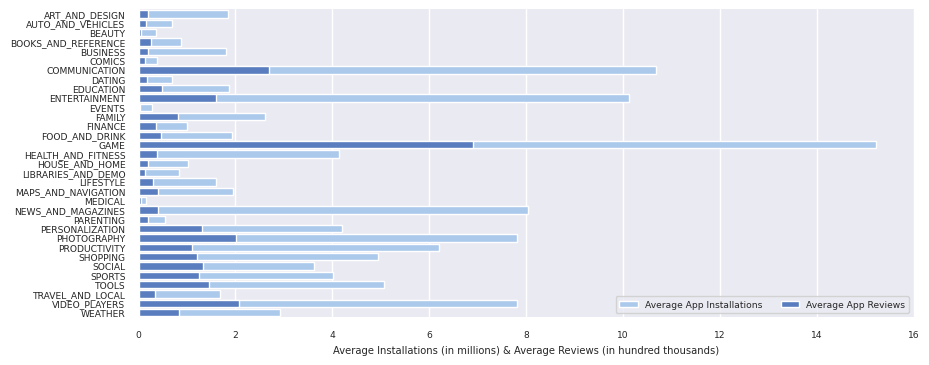

In [23]:
# Set plot theme and initialize figure
sns.set(style='darkgrid',font_scale=0.6)
fig, axs = plt.subplots(figsize=(10,4))

# Plot the Average Downloads
sns.set_color_codes("pastel")
ax1 = sns.barplot(x='AvgInstalls', y='Category', data=table0, label='Average App Installations', color='b')

# Plot the Average Reviews
sns.set_color_codes("muted")
ax2  = sns.barplot(x='AvgReviews', y='Category', data=table0, label='Average App Reviews', color='b')

# Add a legend and informative labels
axs.legend(ncol=2, loc="lower right", frameon=True)
axs.set(xlim=[0,16], ylabel="", xlabel="Average Installations (in millions) & Average Reviews (in hundred thousands)")
sns.despine(left=True, bottom=True)

plt.show()

From the combined bar chart above shows that out of 33 app categories analysed, we can quickly deduce that the **Game** category is by far the most downloaded and most reviewd app category. Other high ranking categories (from mere visual review) would include:
- Communication
- Entertainment
- Photography
- Video players.

But we can define specific limits and make quantitatively deductions of categorical popularity.

If we define the most popular categories as those with **more than 6 million average download OR more than 150 thousand average reviews**, we can use these limits to extract and visualise these categories.

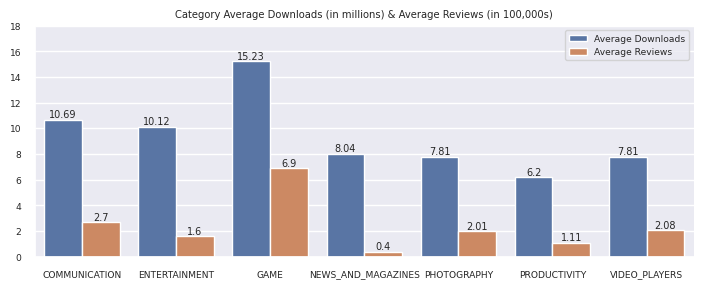

In [24]:
# Extract the category table for most popular app categories
list1 = table0[table0.AvgInstalls > 6].Category.tolist() # Categories with avg. downloads > 6 million
list2 = table0[table0.AvgReviews > 1.5].Category.tolist() # Categories with avg. reviews > 150,000
table1 = table0[table0.Category.isin(list1) | table0.Category.isin(list2)]

# Create temporary long-form dataframe for the bar plot
df = table1.rename(columns={'AvgInstalls':'Average Downloads','AvgReviews':'Average Reviews'})
df = df.melt(id_vars=['Category'],value_vars=['Average Downloads','Average Reviews']) # Un-pivot the table to long-form

# Bar plot of the most popular categories
sns.set(font_scale=.6)
fig, axs = plt.subplots(figsize=[8.5,3])
axs = sns.barplot(x='Category', y='value', hue='variable', data=df)
axs.set(ylim=[0,18], ylabel='', xlabel='', title='Category Average Downloads (in millions) & Average Reviews (in 100,000s)')
axs.legend(ncol=1, loc="upper right", frameon=True)
for i in range(0,len(axs.containers)):
    axs.bar_label(axs.containers[i], fontsize=7)
sns.despine(fig)

plt.show()

We can definiely confirm that our most popular app categories are:
- Communication
- Entertainment
- Game
- News and Magazines
- Photography
- Productivity
- Video players

#### User Engagement

We use a box plot of Rating to further analyse the user engagement across our selected most popular categories.

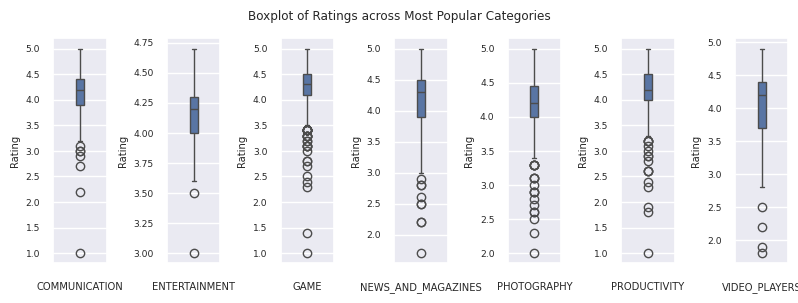

In [25]:
# Box plot of Ratings across Categories
sns.set(font_scale=0.6)
fig, axs = plt.subplots(1, 7, figsize=[8,3])
cat = table1.Category.tolist() # List of the most popular categories
i = 0
for a in axs:
    a = sns.boxplot(y=playstore.Rating[(playstore.Category==cat[i])], width=0.15, ax=axs[i])
    a.set(xlabel=cat[i], ylabel='Rating')
    i += 1

plt.suptitle('Boxplot of Ratings across Most Popular Categories')
plt.tight_layout()
plt.show()

The box plots show that the selected categories all have overwhelmingly positive ratings, with a cumulative mean above 4.0.

But we still need to establish a ranking which will aid our final app profile decision among these most popular apps. 

#### Popularity Index

To establish the popularity rank, we define a **popularity index as the root-sum-square (RSS) value of the average downloads and review counts.**

In [26]:
# Compute the Popularity Index (P-Index)
table1.loc[:,'pindex'] = round((table1.AvgInstalls**2 + table1.AvgReviews**2)**0.5, 1)
table1.loc[:,'pindex_text'] = table1.Category + " (" + table1.pindex.astype(str) + ")"

/tmp/ipykernel_6031/3211732440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table1.loc[:,'pindex'] = round((table1.AvgInstalls**2 + table1.AvgReviews**2)**0.5, 1)
/tmp/ipykernel_6031/3211732440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table1.loc[:,'pindex_text'] = table1.Category + " (" + table1.pindex.astype(str) + ")"


Now we can select and visualize the top-5 popularity indices as a scatter plot of average downloads vs average reviews:

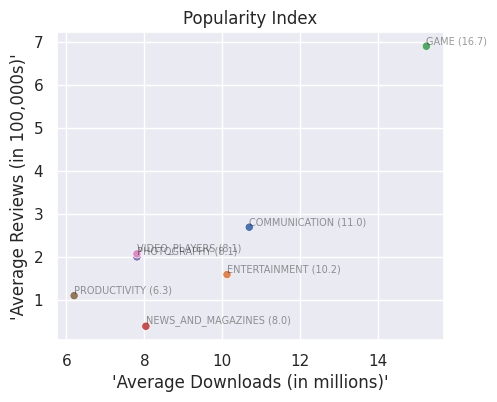

In [27]:
# Scatter plot of the P-indices
sns.set()
fig, axs = plt.subplots(figsize=[5,4])

sns.scatterplot(x='AvgInstalls', y='AvgReviews', hue='Category', data=table1, legend=False)
axs.set(xlabel="'Average Downloads (in millions)'", ylabel="'Average Reviews (in 100,000s)'", title='Popularity Index')

# Annotate the points with corresponding P-index value
for i, row in table1.iterrows():  
    axs.text(row['AvgInstalls'], row['AvgReviews'], row["pindex_text"], 
            fontsize=7, ha='left', va='bottom', color='black', alpha=0.4)

plt.show()

### Determining A Niche Category

The inverse saturation method is an emirical formula utilised in this project to determine niche categories.

The method estimates saturation as an inverse of the ratio of average download to the square of number of apps. The method has no specific upper/lower, however the max/min values calculated are employed as relative references. A niche category is therefore defined as one among most downloaded but with inverse saturation well below the median value across all categories.

This quantity is calculated in the code below and updated in the category freqency table.

#### Saturation Index

We evaluate the results of the calculated saturated indices graphically in a scatter plot:

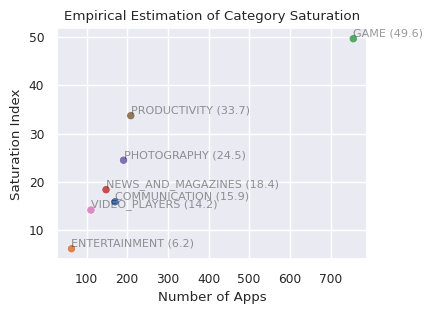

In [28]:
# Computing the 'Saturation Index' for each category
table0.loc[:,'Sat'] = table0.Category + " (" + table0.v3.astype(str) + ")"
df = table0[table0.Category.isin(cat)]

# Scatter plot of top 5 MP ranks
sns.set(font_scale=0.8)
fig, axs = plt.subplots(figsize=[4,3])
sns.scatterplot(x='NumOfApp', y='v3', hue='Category', legend=False, data=df)

axs.set(xlabel='Number of Apps', 
        ylabel='Saturation Index', title='Empirical Estimation of Category Saturation')

# Annotate select points in scatterplot
for i, row in df.iterrows():  
    axs.text(row['NumOfApp'], row["v3"], row["Sat"], 
            fontsize=8, ha='left', va='bottom', color='black', alpha=0.4)
plt.show()

The scatter plot clearly shows the **Entertainment** category as the least saturated (6.2), and thus the best option for introducing a new app with a high chance of popularity and user engagement.

## Summary

Summary of data analysis:

|Category|GAME|COMMUNICATION|ENTERTAINMENT|PHOTOGRAPHY|VIDEO PLAYERS|
|---|---|---|---|---|---|
|Number of Apps||||||
|Popularity Index||||||
|Saturation Index|||||||
|Comments|Very high popularity index, but also highly saturated and extremely competitive. Very visibility for new app entrants; not recommended|High popularity index but also high saturation. Dominated by a few very sucessful and well established app. Not recommended.|**Median popularity index, but very low saturation. Best category for new app entrants.**|High popularity index but also high saturation. Dominated by a few very sucessful and well established app. Not recommended.|High popularity index but also high saturation. Dominated by a few very sucessful and well established app. Not recommended.|

Proposed App Profile:


Final proposed profile:

Category - ENTERTAINMENT 

Target - MOVIES: Watching and streaming movies online

Add-ons - Game-like submenus, like MOVIE QUIZES, etc.

## Acknowledgements

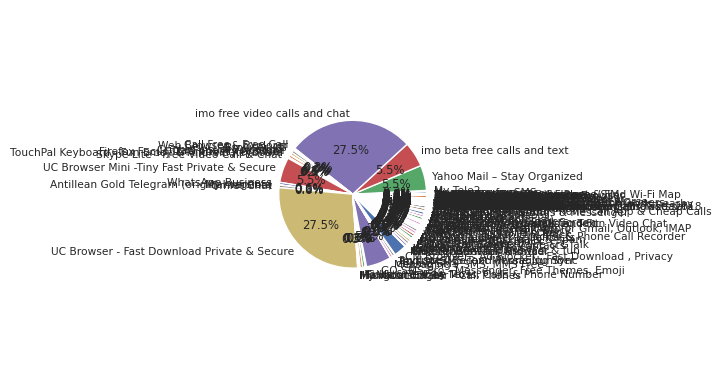

In [29]:
# Plot pie chart for each popular category

sns.set(font_scale=.7)
#fig, axs = plt.figure(figsize=[8,4])

df=playstore[['App','Installs','Reviews']][playstore.Category=='COMMUNICATION']
plt.pie(df.Installs, labels=df.App, radius=0.5, autopct='%.1f%%')
plt.show()